In [42]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import vanet_tools as vp
from scipy.spatial import distance
from collections import defaultdict
from collections import OrderedDict
import xml.etree.ElementTree as ET

In [ ]:
pasubio_sumo = pd.read_csv('pasubio.csv',delimiter=';').dropna()

In [7]:
len(set(pasubio_sumo['vehicle_id']))

8776

In [8]:
pasubio_sumo['timestep_time'].max()

4604.0

In [9]:
coordinates = pasubio_sumo[['vehicle_x','vehicle_y']]

In [10]:
MICROCLOUD_RANGE= 150
NUM_MICROCLOUDS = 20

In [17]:
microcloud_coords =vp.create_coords(coordinates,MICROCLOUD_RANGE,NUM_MICROCLOUDS)
vp.store_microcloud_config(microcloud_coords,'pasubio_config.csv')

In [12]:
# tree = ET.parse('Bologna_small-0.29.0/pasubio/pasubio_buslanes.net.xml')
# root = tree.getroot()

In [13]:
# microcloud_coords = []
# for neighbor in root.iter('junction'):
#     attrib = neighbor.attrib
#     if attrib.get('type')=="priority":
#         x,y = neighbor.attrib.get('x'),neighbor.attrib.get('y')
#         micro_cloud  = [int(float(x)),int(float(y))]
#         microcloud_coords.append(micro_cloud)
# microcloud_coords = microcloud_coords[:NUM_MICROCLOUDS]
# print(microcloud_coords)

In [3]:
microcloud_coords = pd.read_csv('pasubio_config.csv',index_col=0).values

In [8]:
num_physical_pasubio = 4
kmeans = KMeans(n_clusters=num_physical_pasubio).fit(microcloud_coords)
y_kmeans = kmeans.predict(microcloud_coords)

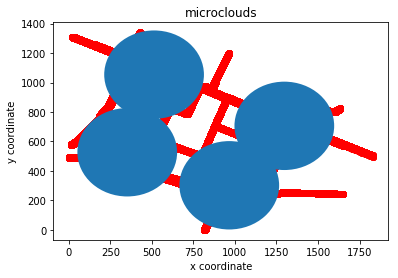

In [25]:
coords_x,coords_y = pasubio_sumo['vehicle_x'],pasubio_sumo['vehicle_y']
vp.plot_microclouds(kmeans.cluster_centers_,300,coords_x,coords_y)

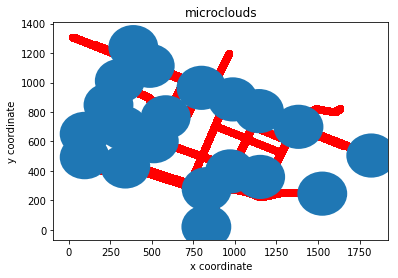

In [26]:
vp.plot_microclouds(microcloud_coords,MICROCLOUD_RANGE,coords_x,coords_y)

In [ ]:
time_col = pasubio_sumo['timestep_time']
start,end = int(time_col.min()), int(time_col.max())

In [28]:
time_steps= pasubio_sumo.groupby('timestep_time')

Paremeters that must be established, mininum amount of trafic for microcloud, relation of power to number of cars

In [31]:
def determine_closest(micro_clouds,x,y):
    min_distance = float('inf')
    index_of_closest = -1
    for index,micro_cloud in enumerate(micro_clouds):
        x_coord,y_coord =  micro_cloud
        current_distance = distance.euclidean((x,y),(x_coord,y_coord))
        if current_distance<min_distance:
            min_distance = current_distance
            index_of_closest = index
    return index_of_closest
            

In [32]:
cloud_to_power = defaultdict(list)
for time in range(start,end+1):
    time_step = time_steps.get_group(time)
    current_power = [0 for _ in range(len(microcloud_coords))]
    for index, row in time_step.iterrows():
        x,y = row['vehicle_x'],row['vehicle_y']
        index_of_closest =determine_closest(microcloud_coords,x,y)
        closest = microcloud_coords[index_of_closest]
        if distance.euclidean((closest[0],closest[1]),(x,y))<MICROCLOUD_RANGE:
            current_power[index_of_closest]+=1
    for index,power in enumerate(current_power):
        cloud_to_power[index].append(power)
            

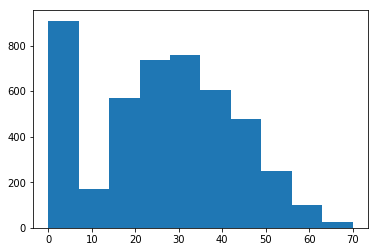

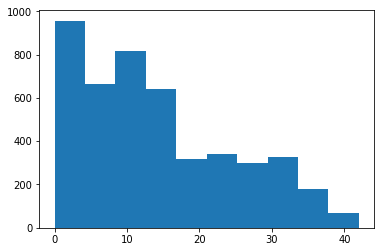

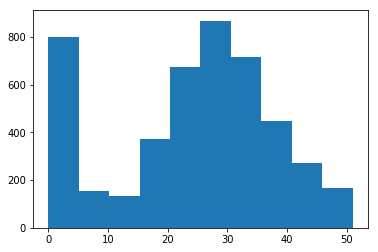

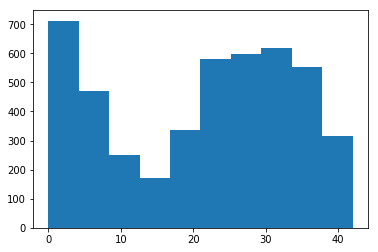

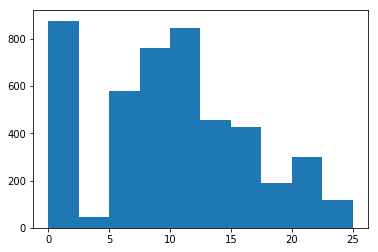

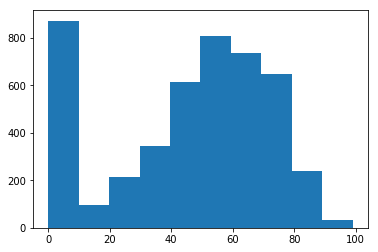

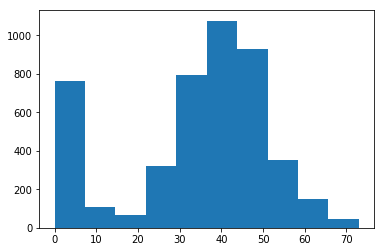

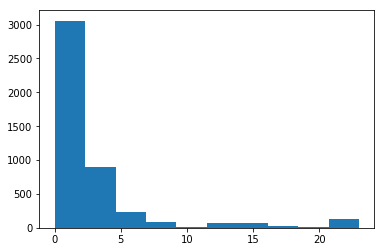

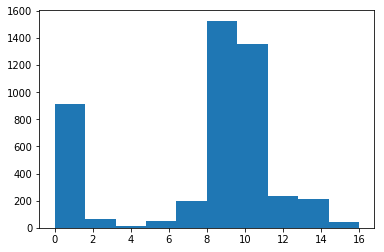

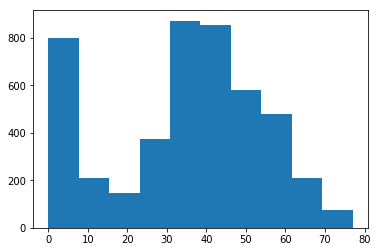

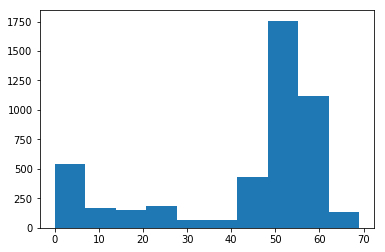

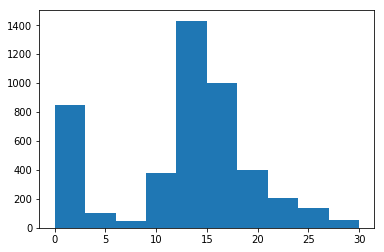

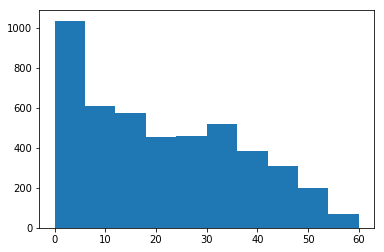

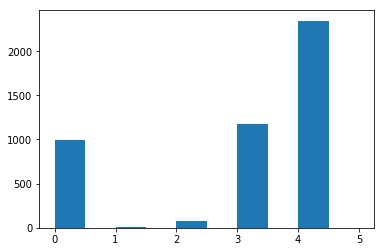

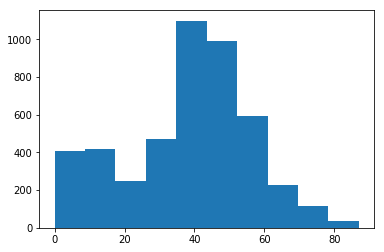

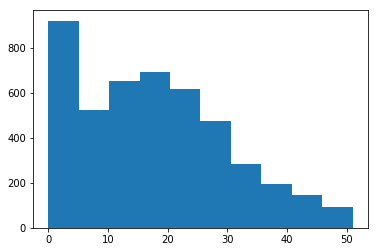

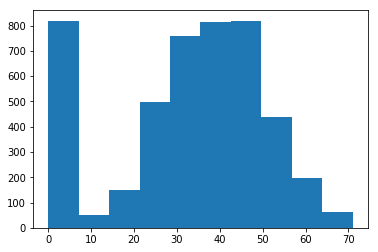

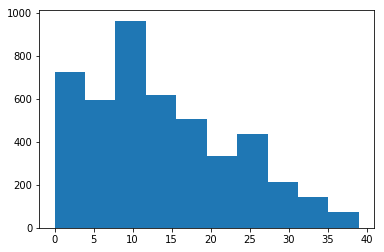

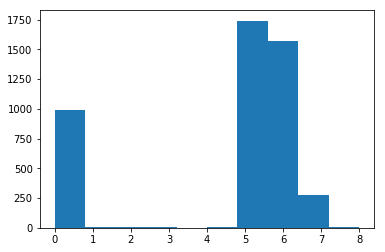

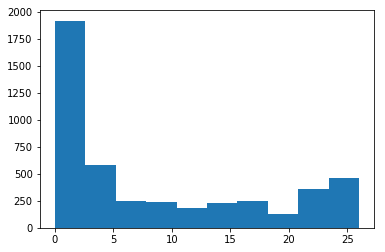

In [33]:
for i in range(len(microcloud_coords)):
    plt.hist(cloud_to_power[i])
    plt.show()

In [34]:
def avg(nums):
    return sum(nums)/len(nums)

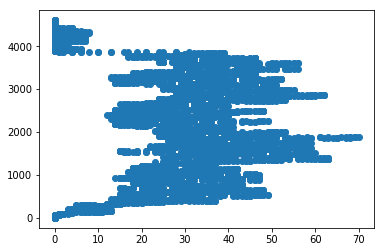

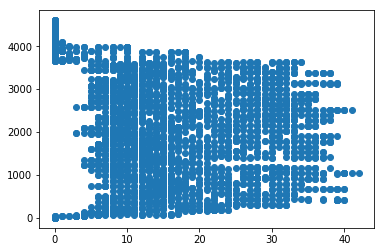

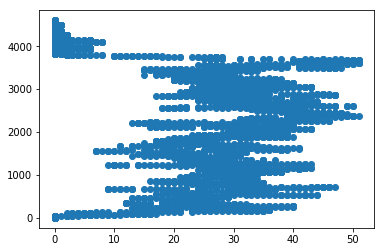

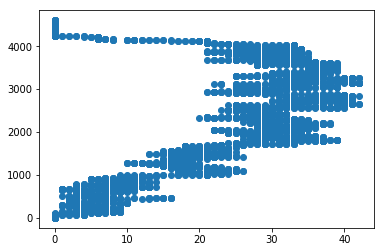

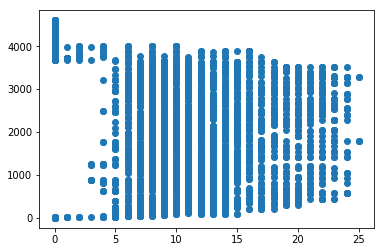

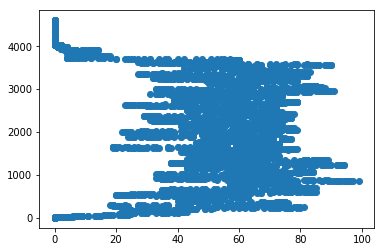

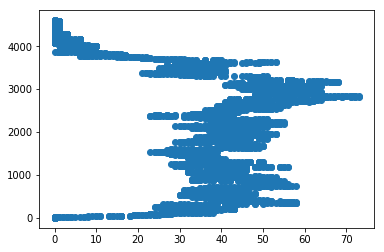

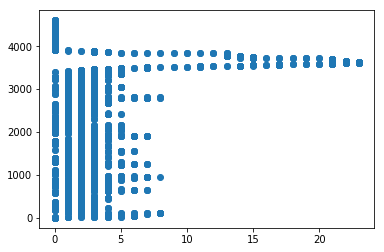

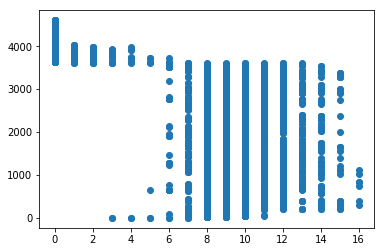

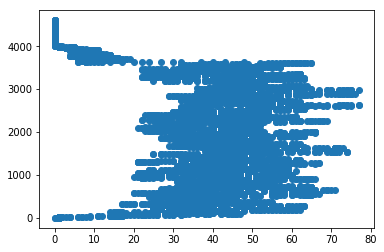

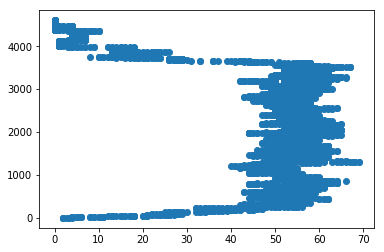

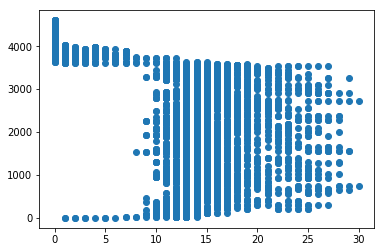

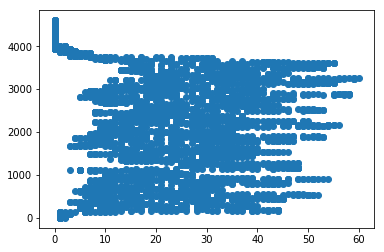

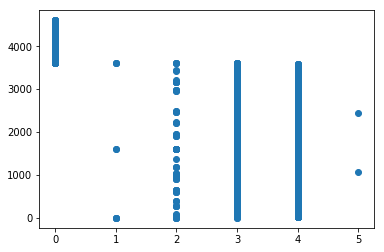

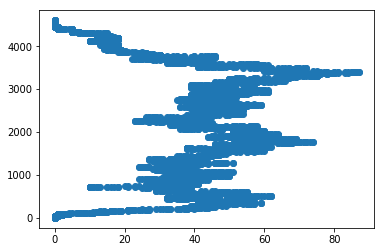

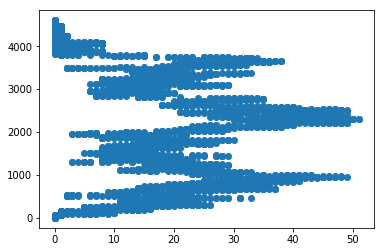

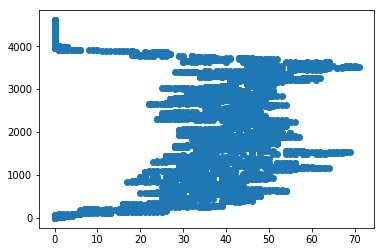

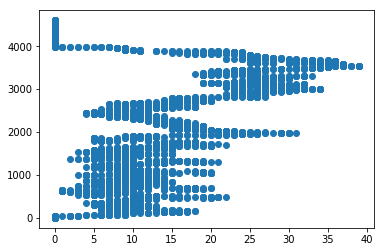

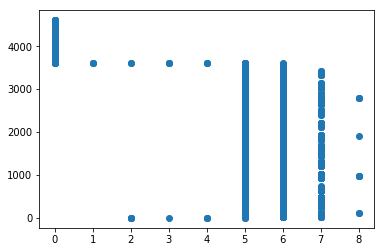

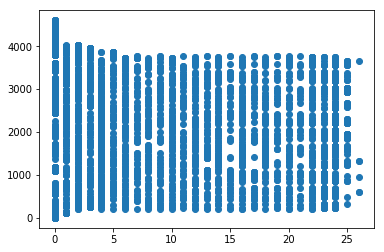

In [35]:
times = [time for time in range(len(cloud_to_power[0]))]
for i in range(len(microcloud_coords)):
    cloud_power = cloud_to_power[i]
    plt.scatter(cloud_power,times)
    plt.show()

In [36]:
def find__reliability(least_cars_needed, cloud_power):
    reliable_time = 0
    for power in cloud_power:
        if (power>=least_cars_needed):
            reliable_time+=1
    return reliable_time/len(cloud_power)

In [37]:
LEAST_CARS_NEEDED = 3

In [101]:
coord_computation_reliability = []

In [102]:
for i in range(len(microcloud_coords)):
    coord = microcloud_coords[i]
    average = avg(cloud_to_power[i])
    reliability = find__reliability(LEAST_CARS_NEEDED,cloud_to_power[i])
    coord_computation_reliability.append([coord, average,reliability])

In [104]:
coord_computation_reliability.sort(key=lambda x: x[0][0])

In [105]:
for t in coord_computation_reliability:
    print(t)

[array([ 95.78, 651.2 ]), 7.686644951140065, 0.7908794788273615]
[array([ 96.03, 493.28]), 12.246036916395223, 0.8154180238870793]
[array([239.35, 847.62]), 9.796525515743756, 0.8095548317046688]
[array([ 307.2, 1011. ]), 13.832356134636266, 0.8056460369163952]
[array([327.51, 692.08]), 2.9346362649294244, 0.33615635179153097]
[array([340.52, 430.18]), 34.359826275787185, 0.859500542888165]
[array([ 388.61, 1240.28]), 43.14766558089033, 0.9431053203040174]
[array([ 487.62, 1113.68]), 25.794788273615634, 0.8538545059717698]
[array([512.04, 601.78]), 13.413897937024974, 0.8466883821932681]
[array([583.51, 763.85]), 20.92985884907709, 0.8833876221498371]
[array([798.81, 964.1 ]), 38.2199782844734, 0.9348534201954397]
[array([828.18,  20.63]), 2.841259500542888, 0.7652551574375679]
[array([829.87, 276.16]), 45.56026058631922, 0.8564603691639522]
[array([970.75, 396.58]), 32.41867535287731, 0.8353963083604777]
[array([987.1 , 885.43]), 17.606731813246473, 0.8330076004343105]
[array([1144.85

In [20]:
coord_computation_reliability = [[list([ 95.78, 651.2 ]), 7.686644951140065, 0.7908794788273615],
[list([ 96.03, 493.28]), 12.246036916395223, 0.8154180238870793],
[list([239.35, 847.62]), 9.796525515743756, 0.8095548317046688],
[list([ 307.2, 1011. ]), 13.832356134636266, 0.8056460369163952],
[list([327.51, 692.08]), 2.9346362649294244, 0.33615635179153097],
[list([340.52, 430.18]), 34.359826275787185, 0.859500542888165],
[list([ 388.61, 1240.28]), 43.14766558089033, 0.9431053203040174],
[list([ 487.62, 1113.68]), 25.794788273615634, 0.8538545059717698],
[list([512.04, 601.78]), 13.413897937024974, 0.8466883821932681],
[list([583.51, 763.85]), 20.92985884907709, 0.8833876221498371],
[list([798.81, 964.1 ]), 38.2199782844734, 0.9348534201954397],
[list([828.18,  20.63]), 2.841259500542888, 0.7652551574375679],
[list([829.87, 276.16]), 45.56026058631922, 0.8564603691639522],
[list([970.75, 396.58]), 32.41867535287731, 0.8353963083604777],
[list([987.1 , 885.43]), 17.606731813246473, 0.8330076004343105],
[list([1144.85,  806.03]), 23.886210640608034, 0.8403908794788274],
[list([1152.1 ,  359.12]), 20.63344191096634, 0.8201954397394137],
[list([1382.55,  699.35]), 34.15352877307275, 0.8699239956568947],
[list([1525.71,  245.55]), 8.343322475570032, 0.5832790445168295],
[list([1820.38,  504.37]), 4.383061889250814, 0.7830618892508143]]

In [27]:
initial_lb = kmeans.cluster_centers_[0]
lb_microclouds = [c_p_r for c_p_r in coord_computation_reliability if distance.euclidean(c_p_r[0],initial_lb)<500]

In [29]:
kmeans.cluster_centers_[0]

array([592.14166667, 996.39      ])

In [28]:
lb_microclouds

[[[239.35, 847.62], 9.796525515743756, 0.8095548317046688],
 [[307.2, 1011.0], 13.832356134636266, 0.8056460369163952],
 [[327.51, 692.08], 2.9346362649294244, 0.33615635179153097],
 [[388.61, 1240.28], 43.14766558089033, 0.9431053203040174],
 [[487.62, 1113.68], 25.794788273615634, 0.8538545059717698],
 [[512.04, 601.78], 13.413897937024974, 0.8466883821932681],
 [[583.51, 763.85], 20.92985884907709, 0.8833876221498371],
 [[798.81, 964.1], 38.2199782844734, 0.9348534201954397],
 [[987.1, 885.43], 17.606731813246473, 0.8330076004343105]]

In [31]:
computation_powers = [c_p_r[1] for c_p_r in lb_microclouds]

In [30]:
min_computation,max_computation  = min(computation_powers),max(computation_powers)
difference = max_computation-min_computation
normalized_computation = [(computation_power-min_computation)/difference for computation_power in computation_powers]

In [119]:
for p in normalized_computation:
    print (p*10+1)

2.706384564291153
3.7099972459377586
1.0
11.0
6.684762475631949
3.6059368941738086
5.474973134392838
9.774604306057318


In [39]:
cloud_df = pd.DataFrame(cloud_to_power)

In [44]:
compute_to_xcoord = OrderedDict()
for c_p_r in cood_computation_reliability:
    compute_to_xcoord[c_p_r[1]] = c_p_r[0][0]

In [46]:
col_to_x_coord = {col:compute_to_xcoord[cloud_df[col].mean()] for col in cloud_df}

In [54]:
xcoord_to_col = {}
for col in col_to_x_coord:
    xcoord_to_col[col_to_x_coord[col]] = col

In [56]:
xcoord_to_col = OrderedDict(sorted(xcoord_to_col.items(),key = lambda t:t))

In [62]:
xcoord_to_col

OrderedDict([(95.78, '8'),
             (96.03, '11'),
             (239.35, '4'),
             (307.2, '1'),
             (327.51, '7'),
             (340.52, '9'),
             (388.61, '10'),
             (487.62, '0'),
             (512.04, '17'),
             (583.51, '3'),
             (798.81, '14'),
             (828.18, '13'),
             (829.87, '5'),
             (970.75, '16'),
             (987.1, '15'),
             (1144.85, '2'),
             (1152.1, '12'),
             (1382.55, '6'),
             (1525.71, '19'),
             (1820.38, '18')])

In [59]:
ordered_cols = xcoord_to_col.values()

In [63]:
final_cloud_df = pd.DataFrame()

In [64]:
for col in ordered_cols:
    final_cloud_df[col] = cloud_df[col]

In [96]:
new_cols= [i for i in range(20)]
final_cloud_df.columns = new_cols

In [98]:
final_cloud_df.to_csv("virtual_servers_config.csv",index_label=False)

In [99]:
final_cloud_df = pd.read_csv("virtual_servers_config.csv")

In [100]:
load_balancer_col = [col for col in final_cloud_df if final_cloud_df[col].mean() in computation_powers ]

In [101]:
load_balancer_df = final_cloud_df[load_balancer_col]

In [105]:
new_cols_lb = [col for col in range(len(load_balancer_df.columns))]
load_balancer_df.columns = new_cols_lb

In [109]:
for i,col in enumerate(load_balancer_df):
    file_name = "VirtualServerConfig/virtual_server"+str(i)+".csv"
    load_balancer_df[col].to_csv(file_name,index=False,header=True)

In [110]:
load_balancer_df.to_csv('lb0_virtual_servers.csv',index=False,header=True)